In [1]:
import keras
from keras import initializers
import tensorflow as tf

# This will make GPU ops as deterministic as possible --> reproducibility
tf.config.experimental.enable_op_determinism()

tf.random.set_seed(42)

import pandas as pd
import numpy as np, os
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre processing

In [4]:
folder_path = f"/content/drive/MyDrive/AI-project/signal_no_artifacts/128"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
list_128 = []

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    list_128.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

In [6]:
folder_path = f"/content/drive/MyDrive/AI-project/signal_no_artifacts/250"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_250.csv')]

list_250 = []

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    list_250.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

# Signal Segmentation

In [7]:
window_size = 200

In [8]:
# Segment each patient's signal

half_window = window_size // 2

#Create a df that will contain the segments
#An id column is added to store the id of the patient
column_names = ['id', 'segment_values', 'label']
df_segments_patients_all = pd.DataFrame(columns=column_names)

id = 0

for patient_data in list_128:
    patient_signal = patient_data['value'].values

  #Iterate through the signal
    for i in range(0, len(patient_signal)):
        #if a peak is detected
        if(patient_data['IsPeak'].values[i] == True):
          #If the margins of the window do not exceed the length of the signal
            if(not(i-half_window <0) and not(i+half_window > len(patient_signal)-1) ):
                segment = patient_signal[i-half_window:i+half_window]

                #Add segment to list only if it is a 'proper window' --> i-window, i+ window garanteed
                df_segments_patient_temp = pd.DataFrame({'id': id,
                                        'segment_values': [segment],
                                        'label': patient_data['PeakNature'].values[i]})
                df_segments_patients_all = pd.concat([df_segments_patients_all, df_segments_patient_temp], ignore_index=True)

    id = id + 1

In [9]:
#Repeat the same operation for the samples sampled at 250
#half_window * 2 considered in order to ensure comparability of signal windows
#For the same reason, take one sample every 2 since 250Hz/128Hz=1,95 ≈2.

for patient_data in list_250:
    patient_signal = patient_data['value'].values

    for i in range(0, len(patient_signal)):
        if(patient_data['IsPeak'].values[i] == True):
            if(not(i-(half_window*2) <0) and not(i+(half_window*2) > len(patient_signal)-1) ):
                segment = patient_signal[i-(half_window*2):i+(half_window*2) : 2]

                #Add segment to list only if it is a 'proper window' --> i-window, i+ window garanteed
                df_segments_patient_temp = pd.DataFrame({'id': id,
                                        'segment_values': [segment],
                                        'label': patient_data['PeakNature'].values[i]})
                df_segments_patients_all = pd.concat([df_segments_patients_all, df_segments_patient_temp], ignore_index=True)

    id = id + 1

# Train / Val / Test split

In [10]:
#Set a seed for reproducibility
np.random.seed(20)

In [11]:
#Split segments depending on the patient id

num_patients = df_segments_patients_all['id'].nunique()

train_indices = np.random.choice(range(num_patients), size=int(num_patients * 0.7), replace=False)
validation_indices = np.random.choice(list(set(range(num_patients)) - set(train_indices)), size=int(num_patients * 0.15), replace=False)
test_indices = list(set(range(num_patients)) - set(train_indices) - set(validation_indices))


In [12]:
#extract from the dataframe containing segments the one belonging to the indexes extracted and put them in train_df
train_df = df_segments_patients_all[df_segments_patients_all['id'].isin(train_indices)].drop(['id'], axis=1)

# Split dataframe into features and labels
X_train = train_df.drop(['label'], axis=1).values
y_train = train_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_train_list = train_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_train_df = pd.DataFrame(X_train_list)
X_train_np = X_train_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['label'])
one_hot_encoded_array_train = one_hot_encoded_df.values

In [13]:
#Show the frequencies of the annotations in the train set

nN = np.count_nonzero(y_train == 'N')
nS = np.count_nonzero(y_train == 'S')
nV = np.count_nonzero(y_train == 'V')

print("Perc N : ")
print(nN/(nN + nS + nV))
print("Perc S : ")
print(nS/(nN + nS + nV))
print("Perc V : ")
print(nV/(nN + nS + nV))

Perc N : 
0.9278707974065905
Perc S : 
0.0348071652964374
Perc V : 
0.03732203729697213


In [14]:
#extract from the dataframe containing segments the one belonging to the indexes extracted and put them in validation_df
validation_df = df_segments_patients_all[df_segments_patients_all['id'].isin(validation_indices)].drop(['id'], axis=1)

# Split dataframe into features and labels
X_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_validation_list = validation_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_validation_df = pd.DataFrame(X_validation_list)
X_val_np = X_validation_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_validation, columns=['label'])
one_hot_encoded_array_validation = one_hot_encoded_df.values

In [15]:
#extract from the dataframe containing segments the one belonging to the indexes extracted and put them in test_df
test_df = df_segments_patients_all[df_segments_patients_all['id'].isin(test_indices)].drop(['id'], axis=1)

# Split dataframe into features and labels
X_test = test_df.drop(['label'], axis=1).values
y_test = test_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_test_list = test_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_test_df = pd.DataFrame(X_test_list)
X_test_np = X_test_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_test, columns=['label'])
one_hot_encoded_array_test = one_hot_encoded_df.values

# Model

In [16]:
#Set a seed for reproducibility
keras.utils.set_random_seed(394)

In [17]:
# Define the CNN architecture
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(window_size, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))

model.add(BatchNormalization())

model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.3)))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(1024))

model.add(Dropout(0.5))

model.add(Activation(tf.keras.layers.LeakyReLU(alpha=0.3)))

model.add(Dense(3, activation='softmax'))

In [18]:
#Implement early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will stop
    verbose=1,
    restore_best_weights=True  # Restore the best model weights when training stops
)

In [19]:
#Calculate weights to manage data unbalance

nN = np.count_nonzero(y_train == 'N')
nS = np.count_nonzero(y_train == 'S')
nV = np.count_nonzero(y_train == 'V')

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wS = round(1-(nS/class_sum),2)
wV = round(1-(nV/class_sum),2)

class_weights_fed = {0: wN, 1: wS, 2: wV}

In [20]:
#Compile the model
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['Accuracy', 'Precision', 'Recall' ])

In [21]:
# Train the model on the training set
history = model.fit(X_train_np,
                    one_hot_encoded_array_train,
                    epochs=20,
                    callbacks=[early_stopping],
                    class_weight = class_weights_fed,
                    validation_data=(X_val_np, one_hot_encoded_array_validation))

Epoch 1/20
3741/3741 [==============================] - 44s 10ms/step - loss: 0.1995 - Accuracy: 0.8026 - precision: 0.8341 - recall: 0.7650 - val_loss: 0.8994 - val_Accuracy: 0.6847 - val_precision: 0.7377 - val_recall: 0.6217
Epoch 2/20
3741/3741 [==============================] - 34s 9ms/step - loss: 0.1175 - Accuracy: 0.8363 - precision: 0.8813 - recall: 0.7863 - val_loss: 0.9868 - val_Accuracy: 0.8576 - val_precision: 0.8578 - val_recall: 0.8575
Epoch 3/20
3741/3741 [==============================] - 33s 9ms/step - loss: 0.0983 - Accuracy: 0.8555 - precision: 0.9083 - recall: 0.8023 - val_loss: 0.5767 - val_Accuracy: 0.8185 - val_precision: 0.9380 - val_recall: 0.6917
Epoch 4/20
3741/3741 [==============================] - 32s 9ms/step - loss: 0.0939 - Accuracy: 0.8616 - precision: 0.9144 - recall: 0.8083 - val_loss: 0.5530 - val_Accuracy: 0.8162 - val_precision: 0.8790 - val_recall: 0.7608
Epoch 5/20
3741/3741 [==============================] - 35s 9ms/step - loss: 0.0925 - Accur

# Evaluate

In [22]:
#Function to plot confusion matrix
def model_evaluation(y_predi, model_name_pred):
    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    cm = confusion_matrix(test_classes, predicted_class)
    classes_name = ['N', 'S', 'V']

    #Normalized cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True,
                fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name_pred)
    plt.show()

In [23]:
#Function to compute different metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def compute_metrics (y_predi):
    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    print("Balanced accuracy score: ", balanced_accuracy_score(test_classes, predicted_class))
    print("Accuracy score: ", accuracy_score(test_classes, predicted_class))
    print("F1 score: ", f1_score(test_classes, predicted_class,average='macro'))
    print("Precision score: ", precision_score(test_classes, predicted_class,average='macro'))
    print("Recall score: ", recall_score(test_classes, predicted_class,average='macro'))

984/984 [==============================] - 2s 2ms/step


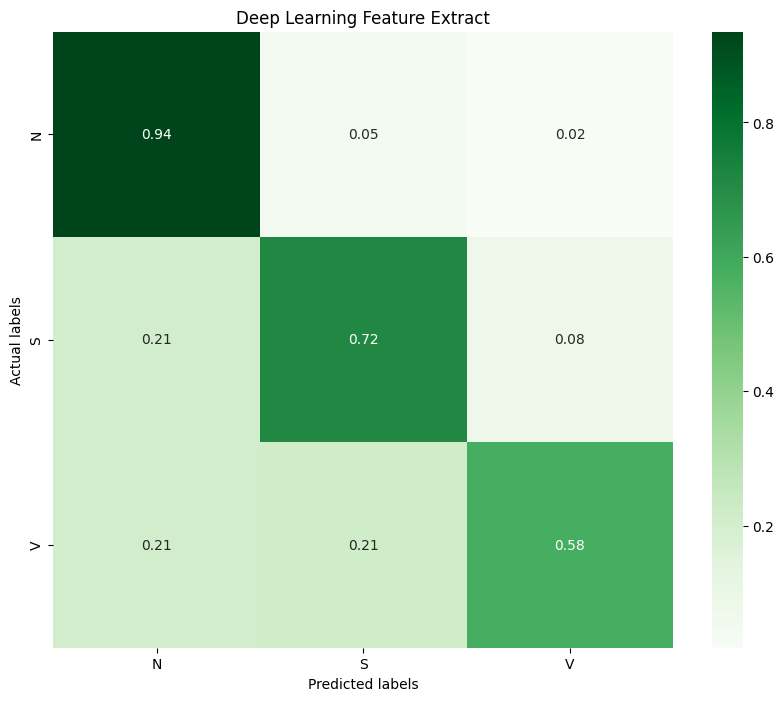

Balanced accuracy score:  0.742616684963009
Accuracy score:  0.9166243171134545
F1 score:  0.6460437831893807
Precision score:  0.5954543767252578
Recall score:  0.742616684963009


In [24]:
#Predict annotations of the test set
y_predi = model.predict(X_test_np)

#Plot confusion matrix
model_evaluation(y_predi, "Deep Learning Feature Extract")

#Print some metrics
compute_metrics(y_predi)

In [25]:
model.save("/content/drive/MyDrive/AI-project/model_seed_394_CM_94_72_58.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Confidence of predictions

In [27]:
#Compute confidence
max_pred = np.argmax(y_predi,axis=1)
classes=pd.DataFrame(data=max_pred,columns=['Predicted class'])
label_remapping = {0:'N', 1: 'S', 2: 'V'}
classes['Predicted class']=classes['Predicted class'].replace(label_remapping)

prob=pd.DataFrame(data=np.take_along_axis(y_predi, np.expand_dims(max_pred, axis=-1), axis=-1),columns=['Confidence'])
conf=pd.concat([classes,prob],axis=1)

print("Average confidence of predictions: ", prob.sum()/len(prob))
conf

Average confidence of predictions:  Confidence    0.775485
dtype: float32


,Predicted class,Confidence
0,N,0.915908
1,N,0.868652
2,N,0.953048
3,N,0.617451
4,N,0.899799
...,...,...
31479,N,0.969208
31480,N,0.968510
31481,N,0.971557
31482,N,0.963607
